(88, 168, 2)


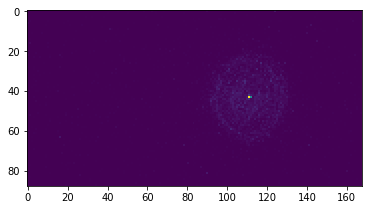

In [1]:
import numpy as np
from iotools import loader_factory
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-']
loader=loader_factory('H5Dataset', batch_size=2, 
                      shuffle=True, num_workers=4, data_dirs=DATA_DIRS, 
                      flavour='100k.h5', start_fraction=0.0, use_fraction=1.0,
                      read_keys=[ 'event_data', 'labels','directions', 'energies', 'pids', 'positions'])
        
#charge and time data in tqev1,tqev2,tqev3
tqev1=[]
tqev2=[]
tqev3=[]
for i,evt in enumerate(loader):    
    tqev1 = evt[0][0]
    tqev2 = evt[0][1]
    tqev3 = np.copy( tqev2 )                                # make a copy of event_data to tqev3
    tqev3[:,:,0] = tqev1[:,:,0] + tqev2[:,:,0]              # add charges
    tqev3[:,:,1] = np.maximum( tqev1[:,:,1], tqev2[:,:,1])  # take maximum time
        
        
    print(tqev1.shape)
    plt.imshow(tqev1[:,:,0])

    
  
    break
    


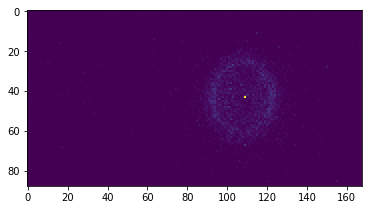

In [2]:
    plt.imshow(tqev2[:,:,0])

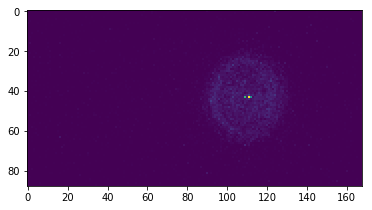

In [3]:
plt.imshow(tqev3[:,:,0])

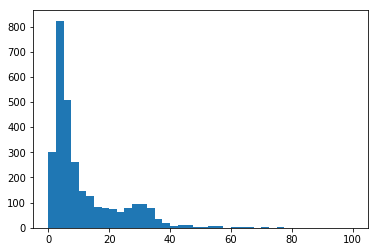

In [4]:
time1_1d = tqev1[:,:,1].reshape(-1)
time1_1d = time1_1d[time1_1d>0]
_ = plt.hist( time1_1d, bins=40, range=(0.,100.)  )
plt.show()

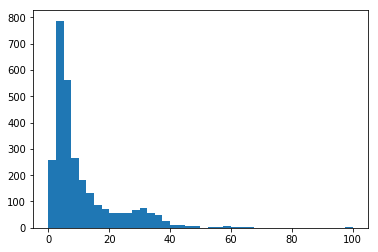

In [5]:
time2_1d = tqev2[:,:,1].reshape(-1)
time2_1d = time2_1d[time2_1d>0]
_ = plt.hist( time2_1d, bins=40,range=(0.,100.) )
plt.show()

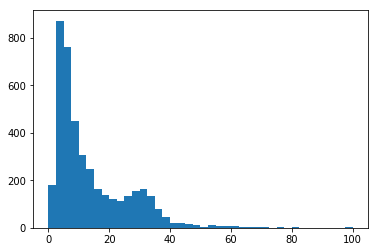

In [6]:
time3_1d = tqev3[:,:,1].reshape(-1)
time3_1d = time3_1d[time3_1d>0]
_ = plt.hist( time3_1d, bins=40,range=(0.,100.)   )
plt.show()